# Grid search example with hyperoptax

In [1]:
import time

import jax
import jax.numpy as jnp
import flax.linen as nn
from flax.training import train_state
import optax
import matplotlib.pyplot as plt

from hyperoptax.grid_search import GridSearch, RandomSearch
from hyperoptax.spaces import LinearSpace, LogSpace

key = jax.random.PRNGKey(0)


In [2]:
# make a basic model
class Model(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(10)(x)
        x = nn.relu(x)
        return nn.Dense(1)(x)


# make a basic dataset
key, key_data = jax.random.split(key, 2)
x = jax.random.uniform(key_data, (1000, 10))
y = 5 * x.mean(axis=1) ** 2 + 2
xtrain = x[:800]
ytrain = y[:800]
xtest = x[800:]
ytest = y[800:]


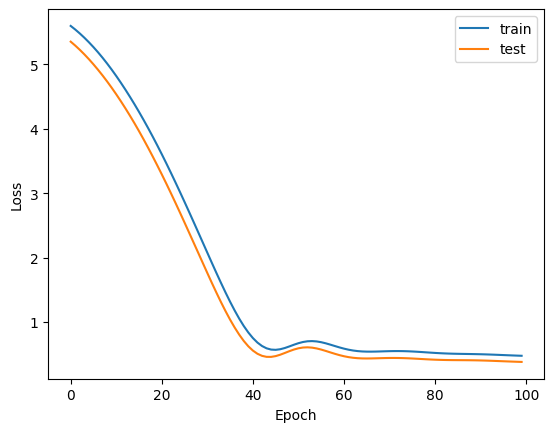

In [3]:
# end to end loop
def make_and_train_model(learning_rate, final_lr_pct, n_epochs=100):
    key = jax.random.PRNGKey(0)
    key, key_init = jax.random.split(key, 2)
    model = Model()
    # make a train state
    ts = train_state.TrainState.create(
        apply_fn=model.apply,
        params=model.init(key_init, jnp.zeros((10,))),
        tx=optax.adamw(
            learning_rate=optax.linear_schedule(
                init_value=learning_rate,
                end_value=final_lr_pct,
                transition_steps=n_epochs,
            )
        ),
    )

    # learning loop
    def train_model(ts, n_epochs):
        def _train_step(ts, carry):
            def _loss(params):
                y_pred = ts.apply_fn(params, xtrain)
                return jnp.mean((y_pred - ytrain) ** 2)

            loss, grads = jax.value_and_grad(_loss)(ts.params)
            ts = ts.apply_gradients(grads=grads)
            return ts, loss

        def _eval_step(ts, carry):
            y_pred = ts.apply_fn(ts.params, xtest)
            return ts, jnp.mean((y_pred - ytest) ** 2)

        def _epoch_step(ts, carry):
            ts, loss_train = _train_step(ts, carry)
            ts, loss_eval = _eval_step(ts, carry)
            return ts, (loss_train, loss_eval)

        ts, losses = jax.lax.scan(_epoch_step, ts, None, n_epochs)
        return ts, losses

    return train_model(ts, n_epochs)


# Plot the losses
ts, losses = make_and_train_model(1e-3, 0.01, 100)
plt.plot(losses[0], label="train")
plt.plot(losses[1], label="test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [4]:
def wrapper(learning_rate, final_lr_pct):
    # get the last validation loss and add a minus as we maximise by default
    return -make_and_train_model(learning_rate, final_lr_pct)[1][1][-1]


search_space = {
    "learning_rate": LogSpace(1e-4, 1e-2, 10),
    "final_lr_pct": LinearSpace(0.01, 0.99, 100),
}
n_iterations = 100

search = GridSearch(search_space, wrapper)

start = time.time()
result = search.optimise(n_iterations, n_parallel=10).flatten()
end = time.time()

print("Optimal result:", result)
print(f"Time taken: {end - start:.2f} seconds to sweep {n_iterations} configs")
print("Optimal loss:", -wrapper(result[0], result[1]))

Optimal result: [0.00599484 0.05949495]
Time taken: 2.90 seconds to sweep 100 configs
Optimal loss: 0.17982173


# Random search

In [5]:
search = RandomSearch(search_space, wrapper)
result = search.optimise(n_iterations).flatten()

print("Optimal result:", result)
print("Optimal loss:", -wrapper(result[0], result[1]))

Optimal result: [0.00215444 0.6930303 ]
Optimal loss: 0.17411242


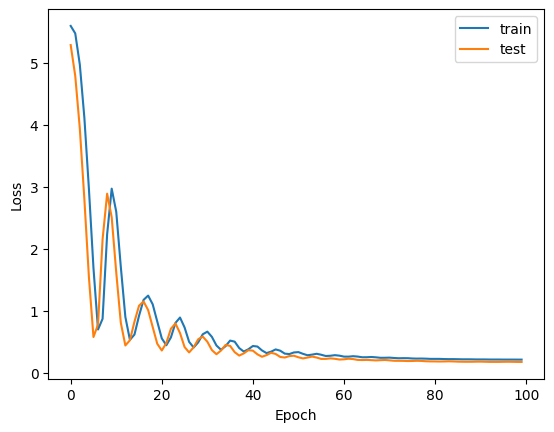

In [9]:
# Plot the losses
ts, losses = make_and_train_model(result[0], result[1], 100)
plt.plot(losses[0], label="train")
plt.plot(losses[1], label="test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()